In [2]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers, Input, Model
from tensorflow.keras.layers import Concatenate
from keras import ops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Exploring the data

x_letters shape: (88799, 28, 28)
y_letters shape: (88799,)
Distinct letter's labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Number of distinct letters: 26


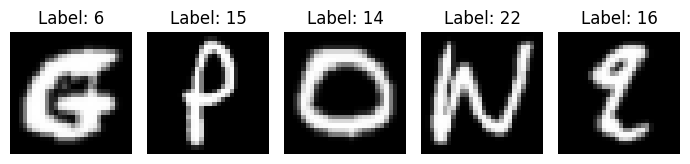

In [3]:
x_letters = np.load('/content/drive/My Drive/Assignment2Data/x_letters.npy')
y_letters = np.load('/content/drive/My Drive/Assignment2Data/y_letters.npy')

print(f"x_letters shape: {x_letters.shape}")
print(f"y_letters shape: {y_letters.shape}")
print(f"Distinct letter's labels: {set(y_letters)}")
print(f"Number of distinct letters: {len(np.unique(y_letters))}")

num_images_to_show = 5

plt.figure(figsize=(7, 5))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(x_letters[i], cmap='gray')
    plt.title(f"Label: {y_letters[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
import os

# List contents of Google Drive root directory
print(os.listdir('/content/drive'))

# List contents of "My Drive"
print(os.listdir('/content/drive/My Drive/Assignment2Data'))

['.shortcut-targets-by-id', '.file-revisions-by-id', 'MyDrive', '.Trash-0', '.Encrypted']
['y_letters.npy', 'x_letters.npy']


# Splitting


In [5]:
y_one_hot = to_categorical(y_letters, num_classes=26)

X_train_full, X_test, Y_train_full, Y_test = train_test_split(x_letters, y_one_hot, stratify = y_letters)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_full, Y_train_full, stratify = Y_train_full)
X_train, X_valid, X_test = X_train/255., X_valid/255., X_test/255.

print(f"x_train shape: {X_train.shape}")
print(f"x_valid shape: {X_valid.shape}")
print(f"x_test shape: {X_test.shape}")

x_train shape: (49949, 28, 28)
x_valid shape: (16650, 28, 28)
x_test shape: (22200, 28, 28)


# GAN
In our GAN, the generator learns to create realistic images by taking random noise and conditioning it on label information (via one-hot encoding) to generate class-specific images. The discriminator is trained to distinguish between real and generated images by looking at both the images and their corresponding labels. An interesting feature here is label smoothing for the discriminator, which slightly adjusts the real/fake labels, making the GAN more stable by preventing the discriminator from becoming overconfident. This setup allows the generator and discriminator to improve iteratively.

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        images_real, labels_one_hot = data

        # Sample random points in the latent space
        batch_size = tf.shape(images_real)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        images_generated = self.generator([random_latent_vectors, labels_one_hot])

        # Combine them with real images
        combined_images = tf.concat([images_real, images_generated], axis=0)

        # Assemble labels discriminating real from fake images
        labels_real_fake = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Apply label smoothing
        labels_real_fake += 0.05 * tf.random.uniform(tf.shape(labels_real_fake))

        # Combine the real and fake labels for the discriminator
        combined_labels = tf.concat([labels_one_hot, labels_one_hot], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(labels_real_fake, predictions)

        # Apply gradients to update discriminator's weights
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space again
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images" (misleading labels for the generator)
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (without updating the discriminator)
        with tf.GradientTape() as tape:
            predicted_labels = self.discriminator([self.generator([random_latent_vectors, labels_one_hot]), labels_one_hot])
            g_loss = self.loss_fn(misleading_labels, predicted_labels)

        # Apply gradients to update generator's weights
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


# Generator and Discriminator


*   **Generator** - Creates 28x28 pixel images based on a random latent vector and a one-hot encoded class label input. We kept the generator's architecture  rather simple with two dense layers that allow for features to be learned. Dropout layers help in regularization, while batch normalization stabilizes training, and reduces the risk of issues like mode collapse and overfitting.

*   **Discriminator** - Classifies input images as real or fake, based on the provided class label. Two danse layers are used for this model as well, and the image input is flattened to make it compatible with the label input


*  **Training step** - RMSprop and binary cross-entropy are used to handle the training of both the generator and discriminator. The learning rates are adjusted so the generator's is slightly higher to balance the training pace.






In [7]:
# Set seeds for reproducibility
np.random.seed(1337)
tf.random.set_seed(1337)
latent_dim = 100

def build_generator(latent_dim):
    latent_input = Input(shape=(latent_dim,), name="latent_input")
    label_input = Input(shape=(26,), name="class_input")


    concat = layers.Concatenate()([latent_input, label_input])

    # First dense layer
    x = layers.Dense(64, activation="relu")(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Second dense layer
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Final output layer
    x = layers.Dense(28 * 28, activation="sigmoid")(x)
    output = layers.Reshape((28, 28))(x)

    generator = Model(inputs=[latent_input, label_input], outputs=output, name="generator")
    return generator


def build_discriminator():
  image_input = Input(shape=(28, 28), name="image_input")
  label_input = Input(shape=(26,), name="class_input")
  flat_image = layers.Flatten()(image_input)
  concat = Concatenate()([flat_image, label_input])

  x = layers.Dense(64,activation="relu",  kernel_initializer="he_normal")(concat)
  x = layers.Dense(128,activation="relu",  kernel_initializer="he_normal")(x)

  output = layers.Dense(1, activation="sigmoid")(x)

  discriminator = Model(inputs=[image_input, label_input], outputs=output, name="discriminator")

  return discriminator

  #---------------------Training------------------------#

epochs = 30

discriminator = build_discriminator()
generator = build_generator(latent_dim)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.003),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

data = data.shuffle(buffer_size=1000).batch(128)

data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

gan.fit(data, epochs=epochs)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - d_loss: 0.4560 - g_loss: 1.8598
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.4817 - g_loss: 1.2889
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.3992 - g_loss: 1.8825
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.5550 - g_loss: 1.0203
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.6390 - g_loss: 0.8121
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.6250 - g_loss: 0.8678
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.6175 - g_loss: 0.8677
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.6266 - g_loss: 0.8642
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.6216 - g_loss: 0.8812
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.6123 - g_loss: 0.8802
Epoch 11/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - d_loss: 0.6447 - g_loss: 0.8353
Epoch 12/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

## Visual results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


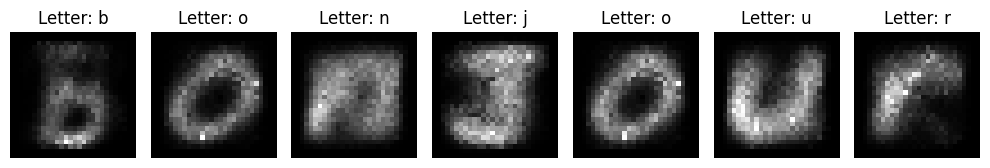

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


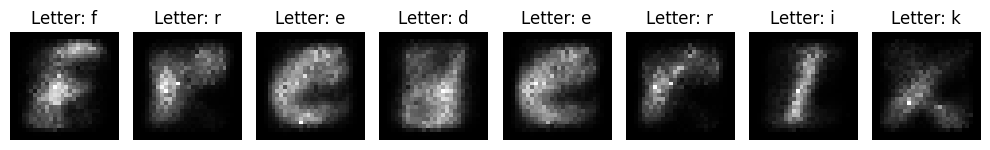

In [8]:
def plot_string(string):
    # Number of letters in the string
    num_letters = len(string)

    # Convert letters to numeric labels (0-25 for A-Z)
    letter_labels = np.array([ord(letter) - 65 for letter in string.upper()])

    # One-hot encode the letter labels
    letter_labels_one_hot = tf.keras.utils.to_categorical(letter_labels, num_classes=26)

    # Creating random latent vectors for each letter
    random_latent_vectors = tf.random.normal(shape=(num_letters, latent_dim))

    # Generating the images using the generator
    generated_images = generator.predict([random_latent_vectors, letter_labels_one_hot])

    # Plotting the generated letters in sequence
    plt.figure(figsize=(10, 5))
    for i, img in enumerate(generated_images):
        plt.subplot(1, num_letters, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Letter: {string[i]}")  # Use the original letter in the title
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_string('bonjour')
plot_string('frederik')

## Comparasion with the real image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


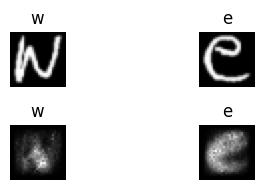

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


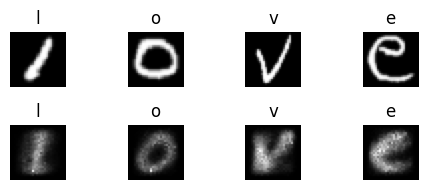

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


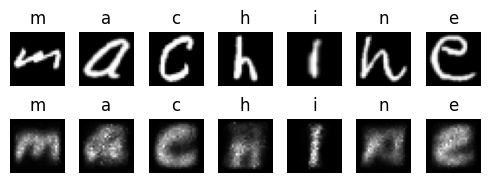

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


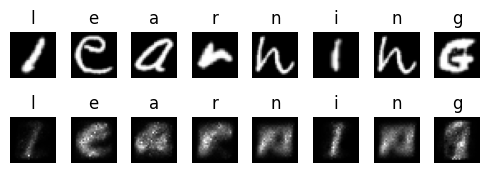

In [9]:
def plot_string(string, x_letters, y_letters):
    num_letters = len(string)
    letter_labels = np.array([ord(letter) - 65 for letter in string.upper()])
    letter_labels_one_hot = tf.keras.utils.to_categorical(letter_labels, num_classes=26)
    random_latent_vectors = tf.random.normal(shape=(num_letters, latent_dim))

    # Generating the images
    generated_images = generator.predict([random_latent_vectors, letter_labels_one_hot])

    # Creating a mask to find the real images corresponding to the letter labels
    real_images = []
    for label in letter_labels:
        # Finding the first occurrence of the letter label in y_letters
        index = np.where(y_letters == label)[0][0]
        real_images.append(x_letters[index])

    real_images = np.array(real_images)

    plt.figure(figsize=(5, 2))
    for i in range(num_letters):
        # real image
        plt.subplot(2, num_letters, i + 1)
        plt.imshow(real_images[i], cmap='gray')
        plt.title(f"{string[i]}")
        plt.axis('off')

        # generated image
        plt.subplot(2, num_letters, i + 1 + num_letters)
        plt.imshow(generated_images[i], cmap='gray')
        plt.title(f"{string[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_string('we', x_letters, y_letters)
plot_string('love', x_letters, y_letters)
plot_string('machine', x_letters, y_letters)
plot_string('learning', x_letters, y_letters)



# Conclusion

*   GANs are UNSTABLE: GANs are unstable, we had to consider both the discriminator and the generator during training. Slightly tuning the hyperparameters of one component significantly impacted the stability of the entire system. In many cases, we found that the generator became too effective, which, paradoxically, resulted in a poorly performing discriminator. Additionally, we experienced mode collapse for a long period of time, which we solved by fine-tuning the hyperparameters and incorporating label smoothing. GANs are sensitive to the choice of hyperparameters, such as learning rates, batch sizes, and architectural decisions, resulting in a complex hypertuning decisions.
*   CNN vs FC: We tried both, Convolutional Neural Network and the Fully connected one and we saw that we got better results for the second one. CNN is still better for images, but it was harder to train in our case. FC come in handy and had better results, since our dataset is not that big.
*   Embedding: Initially, we considered using an embedding dimension of 50 for our data. However, given that our dataset consists of only 26 letters, we decided that one-hot encoding was more appropriate. This approach reduced complexity.
*   RMSprop: RMSprop was chosen as the optimization algorithm because it has adaptive learning rates, which help to reduce overshooting and prevent getting stuck during training. Plus, it converges faster than other optimizers, allowing the model to find an optimal solution more quickly. These characteristics make RMSprop well-suited for generating images.




